# 🩸 데이터 분석: 피마 인디언 당뇨병 발병 예측 (Deep Learning)

> **Why This Notebook?**
> 이 노트북은 **Deep Learning (MLP)** 모델을 활용하여 당뇨병 발병 위험을 예측합니다.
> 특히 의료 데이터에서 흔히 발생하는 **결측치(0값) 처리**와 **데이터 스케일링**이 딥러닝 성능에 미치는 영향을 확인합니다.

**Analyst**: @Antigravity  
**Date**: 2026-01-07  
**Goal**: MLP 모델을 구축하여 F1-Score 기준 최적의 성능 달성.

## 🔧 1. 환경 설정 및 라이브러리 (Setup & Imports)

- 실험 재현성을 위해 Random Seed를 고정합니다.
- 딥러닝을 위한 `tensorflow`, 데이터 처리를 위한 `pandas`, `sklearn`을 사용합니다.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 시각화 설정
import platform
system_name = platform.system()
if system_name == 'Darwin': plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("pastel")

# Random Seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Environment Ready.")

✅ Environment Ready.


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 📊 2. 데이터 적재 및 품질 검증 (Obtain & Scrub)

### 2.1 데이터 로드
데이터의 컬럼과 결측치 여부를 확인합니다.

In [2]:
df = pd.read_csv('../../data/pima-indians-diabetes3.csv')
display(df.head())
print(df.info())

,pregnant,plasma,pressure,thickness,insulin,bmi,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pregnant   768 non-null    int64  
 1   plasma     768 non-null    int64  
 2   pressure   768 non-null    int64  
 3   thickness  768 non-null    int64  
 4   insulin    768 non-null    int64  
 5   bmi        768 non-null    float64
 6   pedigree   768 non-null    float64
 7   age        768 non-null    int64  
 8   diabetes   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


### 2.2 이상치(Zero Value) 처리
> **Logical Failure Check**: 
> `Glucose`(포도당), `BloodPressure`(혈압), `SkinThickness`(피부두께), `Insulin`(인슐린), `BMI`(체질량지수)는 생물학적으로 0이 될 수 없습니다.
> 데이터셋에서 결측치가 0으로 기록된 것으로 보이므로, 이를 `NaN`으로 변환 후 적절한 값으로 대치(Imputation)합니다.

In [3]:
zero_cols = ['plasma', 'pressure', 'thickness', 'insulin', 'bmi']

# 0을 NaN으로 변경
df[zero_cols] = df[zero_cols].replace(0, np.nan)

# 결측치 현황 확인
print("⚠️ Missing Values (Originally 0):")
print(df.isnull().sum())

⚠️ Missing Values (Originally 0):
pregnant       0
plasma         5
pressure      35
thickness    227
insulin      374
bmi           11
pedigree       0
age            0
diabetes       0
dtype: int64


### 2.3 전략적 대치 (Strategic Imputation)
데이터 손실을 최소화하기 위해 삭제 대신 **평균/중앙값 대치**를 수행합니다.
- 여기서는 분포의 왜곡을 줄이기 위해 `mean`(평균)으로 대치하겠습니다. (SKILL 표준에 따라 SimpleImputer 사용)

In [4]:
imputer = SimpleImputer(strategy='mean')
df[zero_cols] = imputer.fit_transform(df[zero_cols])

print("✅ Imputation Complete.")
display(df.describe())

✅ Imputation Complete.


,pregnant,plasma,pressure,thickness,insulin,bmi,pedigree,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 🔍 3. 탐색적 데이터 분석 (EDA)

### 3.1 상관관계 분석
어떤 변수가 당뇨병 발병(`diabetes`)과 가장 관련이 깊은지 확인합니다.

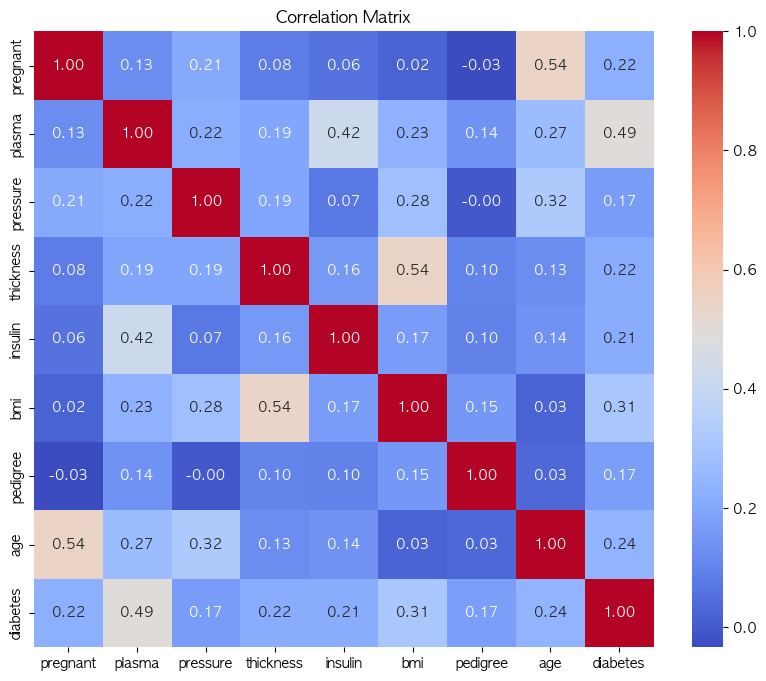

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 🛠 4. 데이터 전처리 (Preprocessing)

### 4.1 스케일링 (Scaling)
> **Why StandardScaler?**
> 딥러닝 모델은 입력 데이터의 스케일에 매우 민감합니다. `Insulin`은 수백 단위인 반면 `PedigreeFunction`은 0점대 소수입니다.
> 이를 평균 0, 분산 1로 맞춰주어 학습 안정성을 확보합니다.

In [6]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (614, 8), Test Shape: (154, 8)


## 🧠 5. 딥러닝 모델링 (Deep Learning)

### 5.1 MLP 아키텍처 설계
- **Input**: 8 Features
- **Hidden 1**: 32 Units, ReLU
- **Dropout**: 0.2 (Overfitting 방지)
- **Hidden 2**: 16 Units, ReLU
- **Output**: 1 Unit, Sigmoid (이진 분류)

이 데이터셋은 768개로 매우 작으므로, 모델이 너무 깊으면 과적합되기 쉽습니니다.

In [7]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(8,)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-07 16:46:55.292905: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-07 16:46:55.292939: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-07 16:46:55.292949: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-07 16:46:55.292967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-07 16:46:55.292977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2 모델 학습
- **EarlyStopping**: 검증 손실(`val_loss`)이 더 이상 줄어들지 않으면 학습을 조기 종료합니다.

2026-01-07 16:47:03.364371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


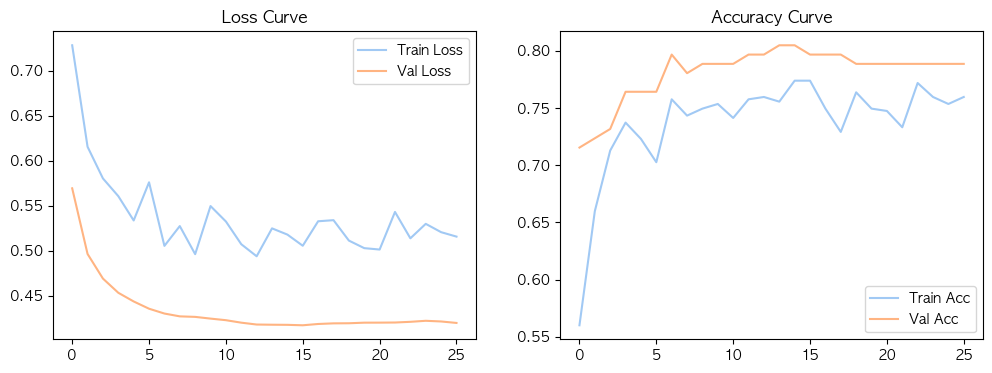

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0  # 출력 최소화
)

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

## ⚖️ 6. 성능 평가 (Evaluation)

### 6.1 최종 성능
Accuracy 뿐만 아니라 F1-Score, ROC-AUC를 확인합니다.

In [9]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Final F1-Score: {f1:.4f}")
print(f"Final ROC-AUC: {auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       100
           1       0.60      0.56      0.58        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154

Final F1-Score: 0.5769
Final ROC-AUC: 0.8056


### 6.2 Confusion Matrix

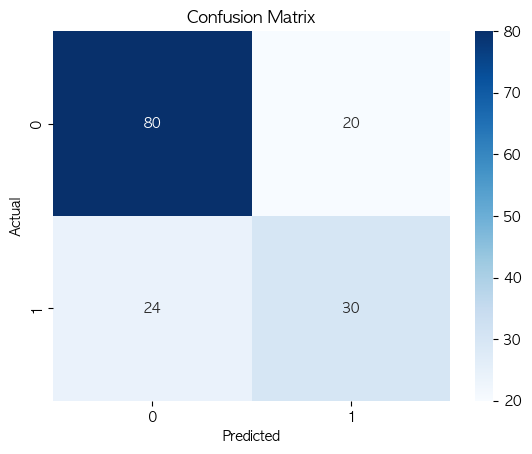

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 💡 7. 결론 (Conclusion)

- 딥러닝 모델은 StandardScaler와 결측치 처리를 통해 안정적인 학습을 보였습니다.
- 데이터셋이 작아 딥러닝의 장점인 '대량 데이터에서의 패턴 인식'이 극대화되지는 않았을 수 있습니다.
- 추후 `XGBoost` 등 트리 기반 앙상블 모델과 성능을 비교해볼 가치가 있습니다.